In [109]:
import os
import random as rnd
import seaborn as sns
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torchaudio
import torch.nn as nn
from torch.nn.functional import normalize
import torch.utils.data as data
from torch.utils.data import DataLoader, Dataset, random_split
from torchvision import datasets
from torchvision.transforms import ToTensor
import torchaudio.prototype.models
import torchaudio.prototype.pipelines
import torch.nn.functional as F
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [110]:
if torch.cuda.is_available():
    print(torch.cuda.get_device_name(0))

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

NVIDIA GeForce RTX 3060


In [111]:
VGGish_pytorch = torchaudio.prototype.pipelines.VGGISH.get_model()

In [112]:
print(VGGish_pytorch)

VGGish(
  (features_network): Sequential(
    (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (11): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (12): ReLU(inplace=True)
    (13): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (14): ReLU(inplace=True)
    (15): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mo

In [113]:
print(torchaudio.__version__)

2.4.0.dev20240707


In [114]:
class SpikerboxRecordings(Dataset):

    def __init__(self, annotations_file, audio_dir, transformation, target_sample_rate, num_samples, device):
        self.annotations = pd.read_csv(annotations_file)
        self.audio_dir = audio_dir
        self.device = device
        self.transformation = transformation.to(self.device)
        self.target_sample_rate = target_sample_rate
        self.num_samples = num_samples
    
    def __len__(self):
        return len(self.annotations)

    def __getitem__(self, index):
        audio_sample_path = self._get_audio_sample_path(index)
        label = self._get_audio_sample_label(index)
        signal, sample_rate = torchaudio.load(audio_sample_path)
        signal = signal.to(self.device)
        signal = self._cut_if_necessary(signal)
        signal = self._right_pad_if_necessary(signal)
        signal = self.transformation(signal)
        signal = self._make_log_mels(signal)
        signal = self._adjust_mel_width_if_necessary(signal, 96)
        return signal, label
    
    def _get_audio_sample_path(self, index):
        path = os.path.join(self.audio_dir, self.annotations.iloc[index, 0])
        return path
    def _resample_if_necessary(self, signal, sample_rate):
        if sample_rate != self.target_sample_rate:
            resampler = torchaudio.transforms.Resample(sample_rate, self.target_sample_rate).to(self.device)
            signal = resampler(signal)
        return signal
    def _get_audio_sample_label(self, index):
        return self.annotations.iloc[index, 1]
    def _cut_if_necessary(self, signal):
        if signal.shape[1] > self.num_samples:
            signal = signal[:, :self.num_samples]
        return signal
    def _right_pad_if_necessary(self, signal):
        length_signal = signal.shape[1]
        if length_signal < self.num_samples:
            num_missing_samples = self.num_samples - length_signal
            last_dim_padding = (0, num_missing_samples)
            signal = torch.nn.functional.pad(signal, last_dim_padding)
        return signal
    def _make_log_mels(self, signal):
        return torchaudio.transforms.AmplitudeToDB().to(self.device)(signal)
    def _adjust_mel_width_if_necessary(self, log_mel_spectrogram, width):
        if log_mel_spectrogram.shape[-1] < width:
            pad_width = width - log_mel_spectrogram.shape[-1]
            log_mel_spectrogram = torch.nn.functional.pad(log_mel_spectrogram, (0, pad_width))
        elif log_mel_spectrogram.shape[-1] > width:
            log_mel_spectrogram = log_mel_spectrogram[:, :, :width]
        return log_mel_spectrogram

In [115]:
ANNOTATIONS_FILE_TRAIN = "../coinproject/train_data/metadata/file_labels.csv"
AUDIO_DIR_TRAIN = "../coinproject/train_data/files"
ANNOTATIONS_FILE_VAL = "../coinproject/valid_data/metadata/file_labels.csv"
AUDIO_DIR_VAL = "../coinproject/valid_data/files"
SAMPLE_RATE = 10000
NUM_SAMPLES = 9600

mel_spectrogram = torchaudio.transforms.MelSpectrogram(
    sample_rate = SAMPLE_RATE,
    n_fft = 400,
    hop_length = 160,
    n_mels = 64
)

spr_train = SpikerboxRecordings(
    ANNOTATIONS_FILE_TRAIN,
    AUDIO_DIR_TRAIN,
    mel_spectrogram,
    SAMPLE_RATE,
    NUM_SAMPLES,
    device
)

In [116]:
spr_train[0][0].shape

torch.Size([1, 64, 96])

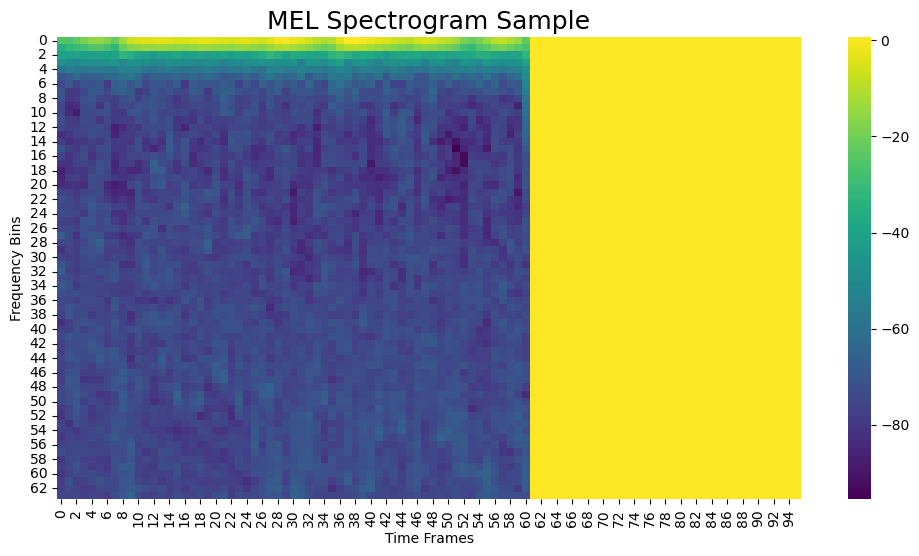

In [117]:
random_position = rnd.randint(0, len(spr_train))
log_mel_tensor_squeezed = np.squeeze(spr_train[random_position][0].cpu(), axis = 0)
plt.figure(figsize = (12, 6))
sns.heatmap(log_mel_tensor_squeezed, cmap = 'viridis')
plt.title('MEL Spectrogram Sample', size=18)
plt.xlabel('Time Frames')
plt.ylabel('Frequency Bins')
plt.savefig("mel_spectrogram_sample.png", dpi = 600)
plt.show()

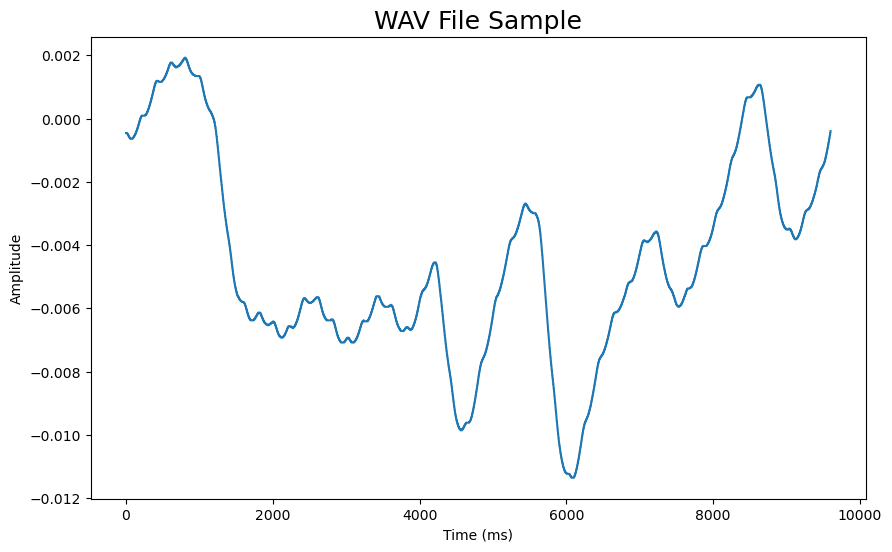

In [118]:
df_labels = pd.DataFrame(pd.read_csv(ANNOTATIONS_FILE_TRAIN))
file_path = f'../coinproject/train_data/files/{df_labels.loc[random_position, "filename"]}'
waveform, sample_rate = torchaudio.load(file_path)
waveform_np = waveform.squeeze().numpy()
plt.figure(figsize = (10, 6))
sns.lineplot(x = range(len(waveform_np)), y = waveform_np)
plt.title('WAV File Sample', size = 18)
plt.xlabel('Time (ms)')
plt.ylabel('Amplitude')
plt.savefig("wav_file_sample.png", dpi = 600)
plt.show()